## **ONLINE stage**

#### LOAD LIBRARIES

In [1]:
# Pulizia
from IPython import get_ipython
get_ipython().magic('clear')
get_ipython().magic('reset -f')

# Import libraries:
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt


/var/folders/gs/p2p59ns16hlgpqv_027665gm0000gn/T/ipykernel_5074/3115343983.py:3: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  get_ipython().magic('clear')
/var/folders/gs/p2p59ns16hlgpqv_027665gm0000gn/T/ipykernel_5074/3115343983.py:4: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  get_ipython().magic('reset -f')


#### MATRICES LOADING

In [2]:
# Apri il file in modalità lettura
with h5py.File('../2. DEIM-POD/matrici_RB.h5', 'r') as hf:
    # Accedi ai dataset e ricrea le matrici
    MM_RB = hf['MM_RB'][:]
    FF_RB = hf['FF_RB'][:]
    KK_RB = hf['KK_RB'][:]
    AA_RB = hf['AA_RB'][:]
    ZZ_CO = hf['ZZ_CO'][:]
    II_CO = hf['II_CO'][:]

#### SELECTION OF THE FULL ORDER PARAMETERS 

In [3]:
# Define universal constants:
FISSION_ENERGY = 3.215E-11                      #[J/fissions]
#FISSION_RATE = np.random.uniform(low=MIN_FR, high=MAX_FR, size=(1))

# Define geometrical parameters:
RADIUS = 1e-05
LENGTH = 1e-03
#RADIUS = np.random.uniform(low=MIN_RR, high=MAX_RR, size=(1))
#LENGTH = np.random.uniform(low=MIN_LL, high=MAX_LL, size=(1))

# Define sources intensity:
FISSION_RATE = 3e19
FISSION_YIELD = 0.24E+00                
FUEL_THERMAL_CONDUCTIVITY = 2.208                                      #[W/(m K)]
SOURCE_C = FISSION_RATE * FISSION_YIELD         #[atm / (m^3 s)]
GAMMA_T = (FISSION_RATE * FISSION_ENERGY * LENGTH**2)/(FUEL_THERMAL_CONDUCTIVITY)

T_BC = 2000
#T_BC = np.random.uniform(low=MIN_BC, high=MAX_BC, size=(1))

TIME_DELTA = 10000

print("The selected Boundary Temperature is", T_BC, "K")
print("The selected Fission Rate is", FISSION_RATE, "f/s")
print("The selected Grain Length is", LENGTH, "m")
print("The selected Grain Radius is", RADIUS, "m")
print("The selected Fission Yield is", FISSION_YIELD, "at/fiss")
print("The selected Fuel Therma Conductivity k is", FUEL_THERMAL_CONDUCTIVITY, "W/(m K)\n")

The selected Boundary Temperature is 2000 K
The selected Fission Rate is 3e+19 f/s
The selected Grain Length is 0.001 m
The selected Grain Radius is 1e-05 m
The selected Fission Yield is 0.24 at/fiss
The selected Fuel Therma Conductivity k is 2.208 W/(m K)



#### CONSTRUCTION OF THE LHS AND RHS

In [4]:
TT = T_BC + GAMMA_T * (1 - ZZ_CO**2) / 2

#SCIANTIX userà il modello scelto dall'utente 
WW = 2.949513e-13 * np.exp(-20487.36244 / (TT));
 
CC_CO = np.hstack((II_CO @ WW / RADIUS**2, II_CO @ WW / LENGTH**2))
 
SS_RB = np.tensordot(CC_CO, KK_RB, axes=[0, 0])
QQ_RB = SOURCE_C * FF_RB
 
LHS_RB_static = MM_RB + TIME_DELTA * SS_RB #matrice + matrice * scalare. Avendo il termine MM_RB al lhs è forward euler, se invece fosse nel RHS sarebbe Backward. 
RHS_RB_static = TIME_DELTA * QQ_RB         #vettore per scalare

### FORWARD EULER

In [5]:
old_sol_RB = np.zeros((MM_RB.shape[0], 1))
reconstructed_solution = np.zeros((1000))
for ii in range(1000):
    old_sol_RB = np.linalg.solve(LHS_RB_static, RHS_RB_static + MM_RB.dot(old_sol_RB))
    value = np.dot(AA_RB, old_sol_RB)[0]
    reconstructed_solution[ii] = value
    print(reconstructed_solution[ii])

6.5401608302233205e+22
1.2768469559737866e+23
1.876501724900377e+23
2.457077899846546e+23
3.0211515013651166e+23
3.570531206330321e+23
4.106576089138546e+23
4.6303558233113135e+23
5.1427410022609675e+23
5.644458296098036e+23
6.136126289269918e+23
6.618279937026235e+23
7.091387919124261e+23
7.55586534590893e+23
8.012083303675983e+23
8.46037618163656e+23
8.90104740054936e+23
9.334373963942052e+23
9.760610125213688e+23
1.0179990379582954e+24
1.0592731932679273e+24
1.0999036757950698e+24
1.1399093327065515e+24
1.1793078077356957e+24
1.218115666566728e+24
1.2563485047067808e+24
1.294021040877237e+24
1.331147198336892e+24
1.367740176074258e+24
1.4038125114380247e+24
1.439376135486418e+24
1.474442422108637e+24
1.5090222317903453e+24
1.5431259507498268e+24
1.5767635260539056e+24
1.609944497227118e+24
1.6426780247892933e+24
1.6749729160921774e+24
1.7068376487722283e+24
1.7382803920921853e+24
1.76930902640666e+24
1.7999311609556307e+24
1.8301541501631774e+24
1.8599851085962667e+24
1.889430924719

#### COMPARISON WITH THE FULL ORDER MODEL

1.0969941065351326e-05


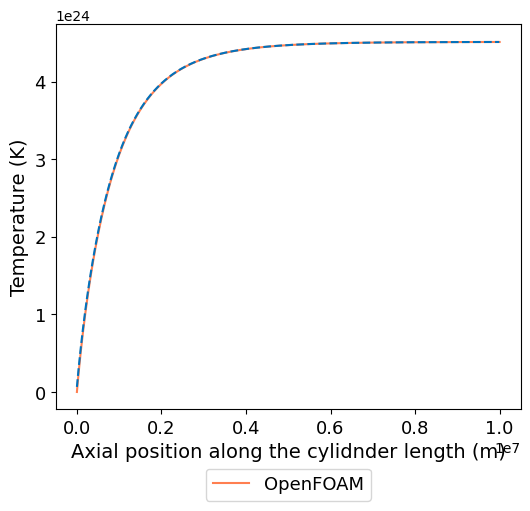

In [6]:
full_order= pd.read_csv('../0. full order/Sensitivity/10Layers_5Refine_0.75Transition_4Center.csv')

error = np.abs(full_order['Average dC (atm/m^3)'].iloc[-1] - reconstructed_solution[-1])/full_order['Average dC (atm/m^3)'].iloc[-1]
print(error)

fig, (ax1) = plt.subplots(1, figsize=(6,5))
ax1.plot(full_order.iloc[:, 0], full_order.iloc[:, 1], label = 'OpenFOAM', color='#FF7F50', linewidth=1.5)
ax1.plot(full_order.iloc[:-1, 0],reconstructed_solution , '--',label = '', color='#0072bd', linewidth=1.5)

ax1.tick_params(axis="y", labelsize=13)
ax1.tick_params(axis='x', labelsize=13)
ax1.ticklabel_format(useOffset=False)
ax1.set_xlabel('Axial position along the cylidnder length (m)',fontsize=14)
ax1.set_ylabel('Temperature (K)',fontsize=14)
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.13), fancybox=True, shadow=False, ncol=2, fontsize=13)
